# TopoDNN Implementation 


The following code implements the preprocessing and training of the TopoDNN network originally proposed in  https://arxiv.org/abs/1704.02124 and evaluated in https://arxiv.org/abs/1902.09914.

Please download the datasets from the link below and place them in the same repository as this code: https://desycloud.desy.de/index.php/s/llbX3zpLhazgPJ6


# Preprocessing


In [2]:
import pandas as pd
import math 
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import keras 
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.optimizers import Adam
import sklearn
from sklearn.metrics import roc_curve

Using TensorFlow backend.


In [3]:
# Read in hdf5 files
# Note: you will need to repeat this processing for input_filenames train, test and val

#input_filename = "train"
#input_filename = "val"
input_filename =  "test"

store = pd.HDFStore(input_filename+".h5", mode="r")
#store = pd.HDFStore(input_filename+".h5")
df = store.select("table")

n_constits = 30 # use only 30 highest pt jet constituents 

In [33]:
def get_pt_eta_phi_v(px, py, pz):
    '''Provides pt, eta, and phi given px, py, pz'''
    # Init variables
    pt = np.zeros(len(px))
    pt = np.sqrt(np.power(px,2) + np.power(py,2))
    phi = np.zeros(len(px))
    eta = np.zeros(len(px))
    theta = np.zeros(len(px))
    x = np.where((px!=0) | (py!=0) | (pz!=0)) # locate where px,py,pz are all 0 
    theta[x] = np.arctan2(pt[x],pz[x]) 
    cos_theta = np.cos(theta)
    y = np.where(np.power(cos_theta,2) < 1)
    eta[y] = -0.5*np.log((1 - cos_theta[y]) / (1 + cos_theta[y]))
    z = np.where((px !=0)|(py != 0))
    phi[z] = np.arctan2(py[z],px[z])
    return pt, eta, phi

def get_px_py_pz_v(pt, eta, phi):
    '''Provides px, py, pz, given pt, eta, and phi'''
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    return px, py, pz

def rotate_v(py, pz, angle):
    '''Rotates vector by angle provided'''
    pyy = py * np.cos(angle) - pz * np.sin(angle)
    pzz = pz * np.cos(angle) + py * np.sin(angle)
    return pyy, pzz

def plot_average_jets(pt, eta, phi, is_sig): 
    '''Makes heat map of average jets for checking effect of preprocessing'''
    if is_sig:
        cmap= sns.cubehelix_palette(rot=-.4,dark=0, light=1,as_cmap=True) #green 
        title = "Signal Jets"
    else: 
        cmap = sns.cubehelix_palette(start=2.8, rot=.1,dark=0, light=1,as_cmap=True) #blue
        title = "Background Jets" 
        
    plt.figure()
    plt.hist2d(eta, phi, 
               bins=[51, 51],
               range=[[-1, 1], [-1, 1]],
               norm=LogNorm(),
               weights= pt,
               cmap = cmap)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(r'Scaled Average Jet p$_\mathrm{T}$ per pixel [AU]')
    plt.xlabel("Translated pseudorapidity $\eta$")
    plt.ylabel("Translated azimuthal angle $\phi$")
    plt.title(title)
    #plt.savefig(name + ".pdf", transparent=True)
    return

In [34]:
# Read in data and change to pt, eta, phi co-ordinates

df_pt_eta_phi = pd.DataFrame()

for j in range(n_constits):
    i = str(j)
    print("Processing constituent #"+str(i))
    px = np.array(df["PX_"+i][0:])
    py = np.array(df["PY_"+i][0:])
    pz = np.array(df["PZ_"+i][0:])
    pt,eta,phi = get_pt_eta_phi_v(px,py,pz)
    df_pt_eta_phi_mini = pd.DataFrame(np.stack([pt,eta,phi]).T,columns = ["pt_"+i,"eta_"+i,"phi_"+i])
    df_pt_eta_phi = pd.concat([df_pt_eta_phi,df_pt_eta_phi_mini], axis=1, sort=False)

df = df.reset_index()
df_pt_eta_phi["is_signal_new"] = df["is_signal_new"]
del df


Processing constituent #0
Processing constituent #1
Processing constituent #2
Processing constituent #3
Processing constituent #4
Processing constituent #5
Processing constituent #6
Processing constituent #7
Processing constituent #8
Processing constituent #9
Processing constituent #10
Processing constituent #11
Processing constituent #12
Processing constituent #13
Processing constituent #14
Processing constituent #15
Processing constituent #16
Processing constituent #17
Processing constituent #18
Processing constituent #19
Processing constituent #20
Processing constituent #21
Processing constituent #22
Processing constituent #23
Processing constituent #24
Processing constituent #25
Processing constituent #26
Processing constituent #27
Processing constituent #28
Processing constituent #29


### Scale Jet Constituents 

Perform min-max scaling on the pt of the jet constituents

In [35]:
MIN_PT = 0.0
MAX_PT = 1679.1593231 # hard-coded from paper

df_pt_eta_phi_scaled = df_pt_eta_phi.copy()
pt_cols = [col for col in df_pt_eta_phi.columns if 'pt' in col]
eta_cols = [col for col in df_pt_eta_phi.columns if 'eta' in col]
phi_cols = [col for col in df_pt_eta_phi.columns if 'phi' in col]
df_pt_eta_phi_scaled[pt_cols]= (df_pt_eta_phi.filter(regex='pt')-MIN_PT)/(MAX_PT-MIN_PT)


### Translate Jet Constituents

Translate jets so that they are centred at (0,0) in $\eta$, $\phi$ co-ordinate plane. 

In [36]:
df_pt_eta_phi_translated = df_pt_eta_phi_scaled.copy()
df_pt_eta_phi_translated[phi_cols]= df_pt_eta_phi_scaled.filter(regex='phi')-MIN_PT

# Translate in eta by the eta of the first constituent
eta_shift = df_pt_eta_phi_scaled['eta_0']
df_pt_eta_phi_translated[eta_cols] = df_pt_eta_phi_scaled.filter(regex='eta')-np.tile(eta_shift, [n_constits,1]).T

# Translate in phi 
phi_shift = np.array(df_pt_eta_phi_scaled['phi_0'])
x = np.where(phi_shift < -math.pi)
y = np.where(phi_shift >= math.pi)
if x:
    phi_shift[x] = phi_shift[x]+2*math.pi
if y:
    phi_shift[y] = phi_shift[y]-2*math.pi

df_pt_eta_phi_translated[phi_cols] = df_pt_eta_phi_scaled.filter(regex='phi')-np.tile(phi_shift, [n_constits,1]).T
del df_pt_eta_phi_scaled

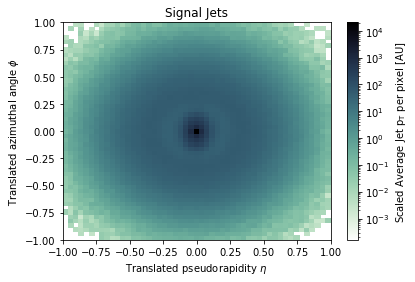

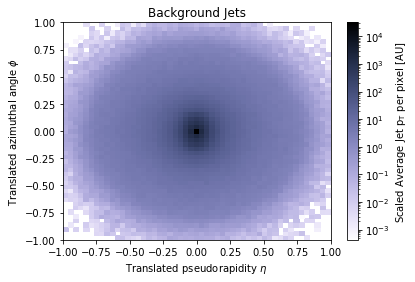

In [37]:
sig = df_pt_eta_phi_translated["is_signal_new"] == 1
bkg = df_pt_eta_phi_translated["is_signal_new"] == 0

# Plot average signal jets  
plot_average_jets(df_pt_eta_phi_translated.loc[sig][pt_cols].values.flatten(),
                  df_pt_eta_phi_translated.loc[sig][eta_cols].values.flatten(),
                  df_pt_eta_phi_translated.loc[sig][phi_cols].values.flatten(),True)
plot_average_jets(df_pt_eta_phi_translated.loc[bkg][pt_cols].values.flatten(),
                  df_pt_eta_phi_translated.loc[bkg][eta_cols].values.flatten(),
                  df_pt_eta_phi_translated.loc[bkg][phi_cols].values.flatten(),False)

### Rotate Jet Constituents

Rotate jets such that their second highest pt jet constituents lies on negative y-axis. 

In [38]:
df_pt_eta_phi_rotated = pd.DataFrame()

# Calculate theta from second jet constituents
pt =  np.array(df_pt_eta_phi_translated['pt_1'])[0:]
eta = np.array(df_pt_eta_phi_translated['eta_1'])[0:]
phi = np.array(df_pt_eta_phi_translated['phi_1'])[0:]
px, py, pz = get_px_py_pz_v(pt,eta,phi)
theta = np.arctan2(py, pz) + math.pi/2

for j in range(n_constits):
    i = str(j)
    pt =  np.array(df_pt_eta_phi_translated['pt_'+i])[0:]
    eta = np.array(df_pt_eta_phi_translated['eta_'+i])[0:]
    phi = np.array(df_pt_eta_phi_translated['phi_'+i])[0:]
     
    # Rotate by theta
    px, py, pz = get_px_py_pz_v(pt,eta,phi)
    py, pz = rotate_v(py, pz, theta)
    pt, eta, phi = get_pt_eta_phi_v(px, py, pz)
    df_pt_eta_phi_mini = pd.DataFrame(np.stack([pt,eta,phi]).T,columns = ["pt_"+i,"eta_"+i,"phi_"+i])
    df_pt_eta_phi_rotated = pd.concat([df_pt_eta_phi_rotated,df_pt_eta_phi_mini], axis=1, sort=False)

df_pt_eta_phi_rotated["is_signal_new"] = df_pt_eta_phi_translated["is_signal_new"]
del df_pt_eta_phi_translated

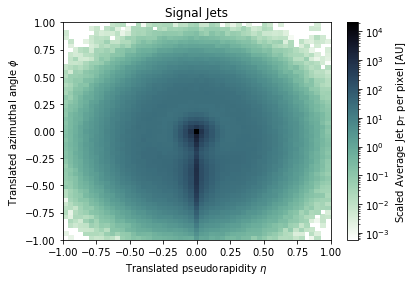

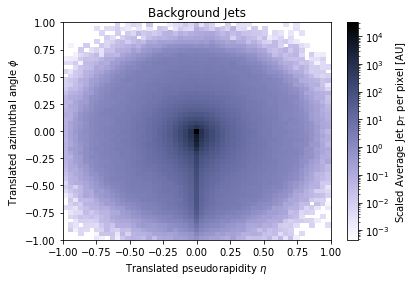

In [39]:
# Plot average signal jets  
plot_average_jets(df_pt_eta_phi_rotated.loc[sig][pt_cols].values.flatten(),
                  df_pt_eta_phi_rotated.loc[sig][eta_cols].values.flatten(),
                  df_pt_eta_phi_rotated.loc[sig][phi_cols].values.flatten(),True)
plot_average_jets(df_pt_eta_phi_rotated.loc[bkg][pt_cols].values.flatten(),
                  df_pt_eta_phi_rotated.loc[bkg][eta_cols].values.flatten(),
                  df_pt_eta_phi_rotated.loc[bkg][phi_cols].values.flatten(),False)

### Flip Jet Constituents

Flip jets where the average jet pt is not along the right side of the plane. 

In [40]:
# Move average jet pt to right hand plane
eta_times_pt = np.multiply(df_pt_eta_phi_rotated.filter(regex='pt'),df_pt_eta_phi_rotated.filter(regex='eta'))
centre = np.sum(eta_times_pt,axis=1)
x = np.where(centre < 0)
df_pt_eta_phi_flipped = df_pt_eta_phi_rotated.copy()
for col in eta_cols: # funny syntax. 
    df_pt_eta_phi_flipped[col].loc[x] = -1.0*df_pt_eta_phi_flipped[col].loc[x]

del df_pt_eta_phi_rotated

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


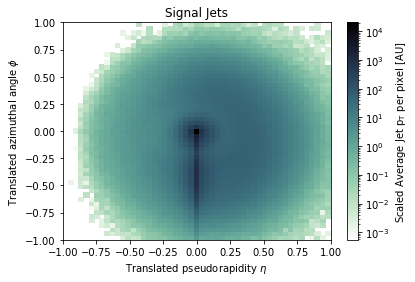

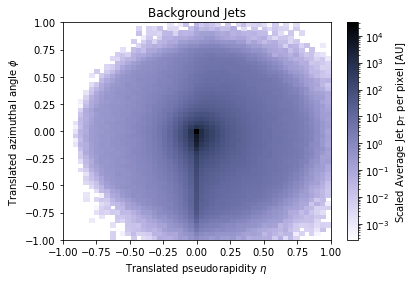

In [41]:
plot_average_jets(df_pt_eta_phi_flipped.loc[sig][pt_cols].values.flatten(),
                  df_pt_eta_phi_flipped.loc[sig][eta_cols].values.flatten(),
                  df_pt_eta_phi_flipped.loc[sig][phi_cols].values.flatten(),True)
plot_average_jets(df_pt_eta_phi_flipped.loc[bkg][pt_cols].values.flatten(),
                  df_pt_eta_phi_flipped.loc[bkg][eta_cols].values.flatten(),
                  df_pt_eta_phi_flipped.loc[bkg][phi_cols].values.flatten(),False)

In [42]:
df_pt_eta_phi_flipped.to_pickle(input_filename+".pkl")

# Training

Make sure to repeat the above steps from cell 2 onwards changing the name of the input dataset for the training, test and validation sets before going ahead with the training. 

In [46]:
k_batch_size = 96

# Load inputs
df_train = pd.read_pickle("train.pkl")
df_val = pd.read_pickle("val.pkl")
x_train = df_train.loc[:, df_train.columns != 'is_signal_new']
y_train = df_train["is_signal_new"]
x_val = df_val.loc[:, df_train.columns != 'is_signal_new']
y_val = df_val["is_signal_new"]
del df_train
del df_val

In [28]:
# Define model 

model = Sequential()
model.add(Dense(300, input_dim=x_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(102))
model.add(Activation('relu'))
model.add(Dense(12))
model.add(Activation('relu'))
model.add(Dense(6))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


In [29]:
# Fit model
history = model.fit(
                x_train,
                y_train,
                batch_size=k_batch_size,
                callbacks=[
                    EarlyStopping(
                        verbose=True,
                        patience=5,
                        monitor='val_loss'),
                    ModelCheckpoint(
                        'best_model',
                        monitor='val_loss',
                        verbose=True,
                        save_best_only=True)],
                        epochs=40,
                        validation_data=(
                    x_val,
                    y_val))


Train on 1211000 samples, validate on 403000 samples
Epoch 1/40
1210176/1211000 [============================>.] - ETA: 0s - loss: 0.2687 - acc: 0.8900
Epoch 00001: val_loss improved from inf to 0.23834, saving model to best_model
1211000/1211000 [==============================] - 65s 53us/step - loss: 0.2686 - acc: 0.8901 - val_loss: 0.2383 - val_acc: 0.9026
Epoch 2/40
1210272/1211000 [============================>.] - ETA: 0s - loss: 0.2287 - acc: 0.9064
Epoch 00002: val_loss improved from 0.23834 to 0.22452, saving model to best_model
1211000/1211000 [==============================] - 62s 51us/step - loss: 0.2288 - acc: 0.9064 - val_loss: 0.2245 - val_acc: 0.9076
Epoch 3/40
1210656/1211000 [============================>.] - ETA: 0s - loss: 0.2177 - acc: 0.9111
Epoch 00003: val_loss improved from 0.22452 to 0.21640, saving model to best_model
1211000/1211000 [==============================] - 61s 50us/step - loss: 0.2177 - acc: 0.9111 - val_loss: 0.2164 - val_acc: 0.9115
Epoch 4/40
1

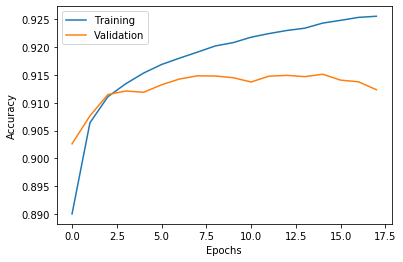

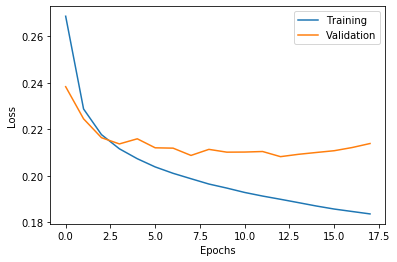

In [30]:
# Plot history

plt.figure()
plt.plot(history.history['acc'],label = "Training")
plt.plot(history.history['val_acc'],label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(history.history['loss'],label = "Training")
plt.plot(history.history['val_loss'],label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Results

In [43]:
df_test = pd.read_pickle("test.pkl")
x_test = df_test.loc[:, df_test.columns != 'is_signal_new']
y_test = df_test["is_signal_new"]
del df_test

model = load_model("best_model")


In [44]:
# Test 
def evaluate_model(model, x_val, y_val):
    score = model.evaluate(x_val, y_val, batch_size=k_batch_size)
    print("Loss: "+str(score[0]))
    print("Acc: "+str(score[1]))
    
    fpr, tpr, thresholds = roc_curve(
            y_val, model.predict(x_val).ravel())
    
    rej_at_30_marker  = None
    rej_at_50_marker  = None
    rej_at_80_marker  = None

    for i in range(len(fpr)):
        if(tpr[i] >= .30 and rej_at_30_marker is None):
            rej_at_30_marker = 1 / fpr[i]
            print("Background rejection at 30\% signal efficiency:" +
                        str(rej_at_30_marker))
        if(tpr[i] >= .50 and rej_at_50_marker is None):
            rej_at_50_marker = 1 / fpr[i]
            print("Background rejection at 50\% signal efficiency:" +
                        str(rej_at_50_marker))
        if(tpr[i] >= .80 and rej_at_80_marker is None):
            rej_at_80_marker = 1 / fpr[i]
            print( "Background rejection at 80\% signal efficiency:" +
                   str(rej_at_80_marker))
    current = sklearn.metrics.auc(fpr, tpr)
    print("AUC:"+str(current))
    return fpr,tpr,current
    
print("Performance on validation set")
_ = evaluate_model(model,x_val,y_val)
print("Performance on test set")
_ = evaluate_model(model,x_test,y_test)

Performance on validation set
403000/403000 [==============================] - 7s 18us/step
Loss: 0.20824385641496768
Acc: 0.9148982630923723
Background rejection at 30\% signal efficiency:281.4287709497207
Background rejection at 50\% signal efficiency:95.13833805476865
Background rejection at 80\% signal efficiency:22.300022133687474
AUC:0.9711761815968472
Performance on test set
404000/404000 [==============================] - 7s 17us/step
Loss: 0.20662436137163992
Acc: 0.916195544511965
Background rejection at 30\% signal efficiency:289.69010043041607
Background rejection at 50\% signal efficiency:96.88771593090212
Background rejection at 80\% signal efficiency:22.467341715811727
AUC:0.9716401356668573


In [45]:
to_save = model.predict(x_test)
np.save('topodnn.npy',to_save.ravel())

# Get Median Model 

For we trained 9 of the same models and then took the median to be uploaded for comparision. 

In [1]:
keras_preds = model.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, keras_preds)
print(len(fpr))

NameError: name 'model' is not defined

In [62]:
print(keras_preds[12300])
print(len(x_test))
print(len(y_test))
print(len(keras_preds))

0.5502734
404000
404000
404000


Test------------------------------------
best_model----------------------------------------------
404000/404000 [==============================] - 4s 10us/step
Loss: 0.20806926023428984
Acc: 0.9157475244880903
Background rejection at 30\% signal efficiency:290.52374100719425
Background rejection at 50\% signal efficiency:94.30826716487623
Background rejection at 80\% signal efficiency:22.108179130625206
AUC:0.9712659620988886


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


Median AUC: 0.9712659620988886
Median model: best_model
Saving predictions for median model


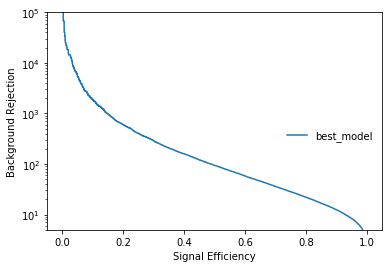

In [83]:

# Test 
def evaluate_model(model, x_val, y_val):
    score = model.evaluate(x_val, y_val, batch_size=k_batch_size)
    print("Loss: "+str(score[0]))
    print("Acc: "+str(score[1]))
    
    fpr, tpr, thresholds = roc_curve(
            y_val, model.predict(x_val).ravel())
    np.save("fpr",fpr)
    np.save("tpr",tpr)

    rej_at_30_marker  = None
    rej_at_50_marker  = None
    rej_at_80_marker  = None

    for i in range(len(fpr)):
        if(tpr[i] >= .30 and rej_at_30_marker is None):
            rej_at_30_marker = 1 / fpr[i]
            print("Background rejection at 30\% signal efficiency:" +
                        str(rej_at_30_marker))
        if(tpr[i] >= .50 and rej_at_50_marker is None):
            rej_at_50_marker = 1 / fpr[i]
            print("Background rejection at 50\% signal efficiency:" +
                        str(rej_at_50_marker))
        if(tpr[i] >= .80 and rej_at_80_marker is None):
            rej_at_80_marker = 1 / fpr[i]
            print( "Background rejection at 80\% signal efficiency:" +
                   str(rej_at_80_marker))
    current = sklearn.metrics.auc(fpr, tpr)
    print("AUC:"+str(current))
    return fpr,tpr,current

models = glob.glob("best_model*")

plt.figure()
print("Test------------------------------------")
aucs = []
for my_model in models: 
    print(my_model+"----------------------------------------------")
    model = load_model(my_model)
    fpr, tpr, auc = evaluate_model(model,x_test,y_test)
    aucs += [auc]
    plt.plot(tpr,1.0/fpr,label=my_model)
    plt.ylim((5, 1e5))
    plt.yscale('log')
plt.legend(frameon=False, bbox_to_anchor=(1, 0.5))
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.savefig("rocs_test.png")

median_auc = np.median(aucs)
median_model = models[np.where(aucs==median_auc)[0][0]]

print("Median AUC: "+str(median_auc))
print("Median model: "+str(median_model))

# Save prediction from best model
print("Saving predictions for median model")
model = load_model(median_model)
to_save = model.predict(x_test)
np.save('topodnn_30.npy',to_save.ravel())
